In [13]:
import subprocess
from multiprocessing import Pool,cpu_count
import os
from itertools import product,repeat
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import spline
from scipy.ndimage.filters import gaussian_filter1d
from scipy import stats
import fileinput as fi

%run averaging.ipynb
%run optimize_slope.ipynb

ncores=cpu_count()

In [2]:
area_er = 2*(3.9+0.1+0.1*0.1+3.9*0.1)
vol_er = (3.9*0.1*0.1)
vol_cyt = (4.0*0.5*0.5-vol_er)
vol_tot = vol_cyt + vol_er
N_avo=6.0221409e23

# Initial RSnostim equilibrium check

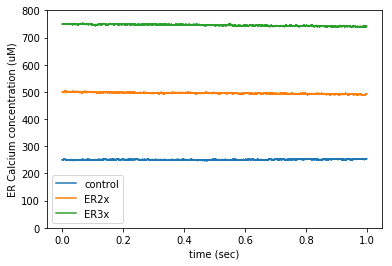

In [333]:
sims=["R150control","R150ER2x","R150ER3x","R300ER2x","R300ER3x"]
data_loc="/data/kabir/output/ppf/"
sim_type="RSnostim"

data_type=["ca.dat","pmca&leak_ca_flux.dat","serca_ca_flux.dat"]

plt.figure(figsize=(6,4))
for s in sims[0:3]:
    data_folder=data_loc+s+'/'+sim_type
    data_file=data_folder+"/s_00001/dat/"+data_type[0]
    ca_dat=np.loadtxt(data_file)
    #print(ca_dat)
    ydata=ca_dat.T[3]*1e15/N_avo/vol_er*1e6
    #ydata=ca_dat.T[2]-ca_dat.T[1]
    xdata=ca_dat.T[0]
    plt.plot(xdata,ydata,label=s.replace('R150',''))
plt.legend()
plt.xlabel("time (sec)")
plt.ylabel("ER Calcium concentration (uM)")

plt.ylim((0,800))
plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/equilibrium.eps")

# Search and Replace in files

In [67]:
dataloc="/home/kabir/Project/tripartiteSynapse/mcell/R300ER2x/"
files=os.listdir(dataloc)
RSI_files=[]
for f in files:
    if "RSI" in f:
        RSI_files.append(f)
#RSI_files

In [68]:
for fn in RSI_files:
    with fi.FileInput(dataloc+fn,inplace=True, backup='.bak') as f:
        for line in f:
            print(line.replace('"ppf/"','"ppf/R300ER2x/"'), end='')

# kleak conversion to mcell

In [69]:
#from S Bandara et al 2013
J=0.07*250 #uM/s
J/=1e15/N_avo/vol_er*1e6
print("Ca Flux in ions/sec = ",J)

p=[2.1675959461586873, 6.214988757731395]
kleak=(J-p[1])/p[0]
print("Predicted kleak = ",kleak)

Ca Flux in ions/sec =  411.01111642500007
Predicted kleak =  186.74888573427603


# creating run.sh file

In [53]:
def seed_num(fname):
    vdcc_num=int(fname.split('V')[1].replace('.mdl',''))
    if vdcc_num>=110 and vdcc_num<=160:
        return 1000
    elif vdcc_num>=90 and vdcc_num<=100:
        return 2000
    elif vdcc_num>=70 and vdcc_num<=80:
        return 3000
    elif vdcc_num>=40 and vdcc_num<=60:
        return 5000
    else:
        return 10

In [151]:
a="""for name in fnames:
    input_loc=script_folder+'/'+name.replace('V90','V80')
    output_loc=script_folder+'/'+name
    with open(input_loc,'r') as infile:
        lines=infile.readlines()
    
    lines=[line.replace("VDCC_number_presynaptic = 80","VDCC_number_presynaptic = 90") for line in lines]
        
    with open(output_loc,'w') as outfile:
        outfile.writelines(lines)
#"""            

In [295]:
#ISI range

sims=["R150control","R150ER2x","R300ER2x","R150ER3x","R300ER3x"]
sim_type=sims[0]
script_folder="/home/kabir/Project/tripartiteSynapse/mcell"+'/'+sim_type
print(script_folder)
isi=list(range(20,101,20))
VDCC=[90]
print('isi = '+str(isi),'\nvdcc = '+str(list(VDCC)))
fnames=[]
for (i,v) in product(isi,VDCC):
    fnames.append("RSI"+str(i)+"V"+str(v)+".mdl")
#fnames=["RSI20V90.mdl","RSI30V90.mdl","RSI40V90.mdl"]
print(fnames)
#seed_num=1000

/home/kabir/Project/tripartiteSynapse/mcell/R150control
isi = [20, 40, 60, 80, 100] 
vdcc = [90]
['RSI20V90.mdl', 'RSI40V90.mdl', 'RSI60V90.mdl', 'RSI80V90.mdl', 'RSI100V90.mdl']


In [334]:
#VDCC range

sims=["R150control","R150ER2x","R300ER2x","R150ER3x","R300ER3x"]
sim_type=sims[2]
script_folder="/home/kabir/Project/tripartiteSynapse/mcell"+'/'+sim_type
print(script_folder)
isi=[20]
VDCC=list(range(60,101,20))
print('isi = '+str(isi),'\nvdcc = '+str(list(VDCC)))
fnames=[]
for (i,v) in product(isi,VDCC):
    fnames.append("RSI"+str(i)+"V"+str(v)+".mdl")
print(fnames)

/home/kabir/Project/tripartiteSynapse/mcell/R300ER2x
isi = [20] 
vdcc = [60, 80, 100]
['RSI20V60.mdl', 'RSI20V80.mdl', 'RSI20V100.mdl']


In [287]:
#3003x

sims=["R150control","R150ER2x","R300ER2x","R150ER3x","R300ER3x"]
sim_type=sims[4]
script_folder="/home/kabir/Project/tripartiteSynapse/mcell"+'/'+sim_type
print(script_folder)
isi=[20]
VDCC=[70]
print('isi = '+str(isi),'\nvdcc = '+str(list(VDCC)))
fnames=[]
for (i,v) in product(isi,VDCC):
    fnames.append("RSI"+str(i)+"V"+str(v)+".mdl")
print(fnames)

/home/kabir/Project/tripartiteSynapse/mcell/R300ER3x
isi = [20] 
vdcc = [70]
['RSI20V70.mdl']


In [231]:
#write run.sh
with open(script_folder+'/run.sh','w') as f:
    for name in fnames:
            loc=script_folder+'/'+name
            f.write("sed --i 's/^#PBS -J.*/#PBS -J 1-"+str(seed_num(name))+"/' pbs.py\n")
            f.write("qsub -N "+name.replace(".mdl",sim_type).replace("RSI",'I')+" -v I='"+loc.replace('/kabir/Project/','/subhadra/kabir/')+"' pbs.py\n")
            f.write("\n")

#sync script files to cluster
p=subprocess.call(["rsync","-arhP",script_folder,"subhadra@192.168.1.244:/home/subhadra/kabir/tripartiteSynapse/mcell/"])

/home/kabir/Project/tripartiteSynapse/mcell/R300ER2x
isi = [20] 
vdcc = [60]
['RSI20V60.mdl']


In [280]:
outfolder='AD/RSI40V90'

In [41]:
outfolder='AD'#RSI40V90'

In [42]:
#sync data back to this system
p=subprocess.call(["rsync","-arhP","subhadra@192.168.1.244:/storage/subhadra/kabir/output/ppf/"+outfolder,"/data/kabir/output/ppf/"])

In [156]:
outfolder='R150control'#RSI40V90'

In [157]:
#sync data back to this system
p=subprocess.call(["rsync","-arhP","subhadra@192.168.1.244:/storage/subhadra/kabir/output/ppf/"+outfolder,"/data/kabir/output/ppf/"])

R300ER2x RSI20V100.mdl
R300ER2x RSI20V60.mdl
R300ER2x RSI20V80.mdl

Calculating Average of
Calculating Average of
Calculating Average of /dat/ca.dat
 /dat/ca.dat
RSI20V100
 /dat/ca.dat
RSI20V80
RSI20V60
seeds:  2000
seeds:  3000
seeds:  5000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R300ER2x/RSI20V100/ca.dat
Calculating Calcium Concentration...
Writing Ca Conc. to file:/CaConc
isi:  20 
vdcc:  100
seeds:  2000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R300ER2x/RSI20V80/ca.dat
Calculating Calcium Concentration...
Writing Ca Conc. to file:/CaConc
isi:  20 
vdcc:  80
seeds:  3000
resampling: 100
resampling: 200
resampling: 300
resampling: 400
resampling: 100
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R300ER2x/RSI20V60/ca.dat
Calculating Calcium Concentration...
Writing Ca Conc. to file:/CaConc
isi:  20 
vdcc:  60
seeds:  5000
resampling: 500
resampling: 200
resampling: 600
resampling: 300
resampling: 700
re

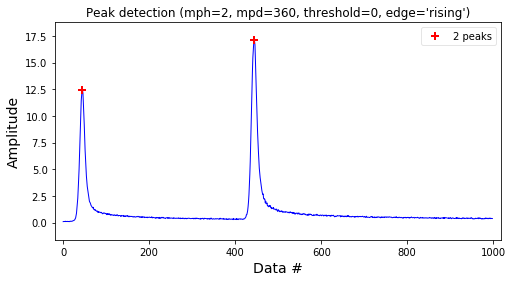

isi:  20 
vdcc:  100
Ca stats:
 [2.20000000e-03 1.24682170e+01 1.92199630e-02 2.22000000e-02
 1.70760230e+01 2.80970405e-02]
Ca stats:
 [2.20000000e-03 1.24682170e+01 1.92199630e-02 2.22000000e-02
 1.70760230e+01 2.80970405e-02 2.00000000e+01 1.00000000e+02]
resampling: 600
resampling: 700
resampling: 100
resampling: 800
resampling: 900
resampling: 200
resampling: 1000
Vesicle release stats:
 [0.06614566666666677, 0.0044576280563646065, 0.2606030000000001, 0.008215679582359572, 3.9584222690063227, 0.3037465007881673, 0.734729647839052, 0.008447799106212675, 0.2652703521609476, 0.00844779910621268, 0.8053061282025414, 0.02786197147326134, 0.19469387179745754, 0.02786197147326133, 20.0, 80.0]


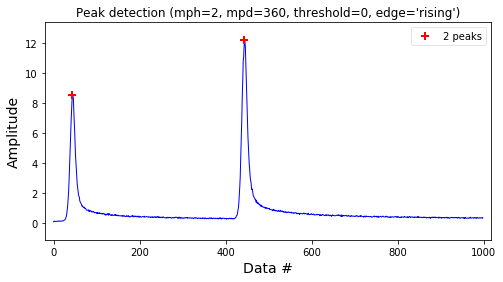

isi:  20 
vdcc:  80
Ca stats:
 [2.20000000e-03 8.52355100e+00 1.46416938e-02 2.22000000e-02
 1.21763190e+01 2.12270679e-02]
Ca stats:
 [2.20000000e-03 8.52355100e+00 1.46416938e-02 2.22000000e-02
 1.21763190e+01 2.12270679e-02 2.00000000e+01 8.00000000e+01]
resampling: 300
resampling: 400
resampling: 500
resampling: 600
resampling: 700
resampling: 800
resampling: 900
resampling: 1000
Vesicle release stats:
 [0.010372999999999973, 0.0014790101419530543, 0.06336240000000007, 0.0034361644663781707, 6.240715590359101, 1.0102600797439438, 0.9363749492682212, 0.003448492542456254, 0.06362505073177786, 0.003448492542456256, 0.9618147450378243, 0.028120819405334556, 0.03818525496217779, 0.028120819405334525, 20.0, 60.0]


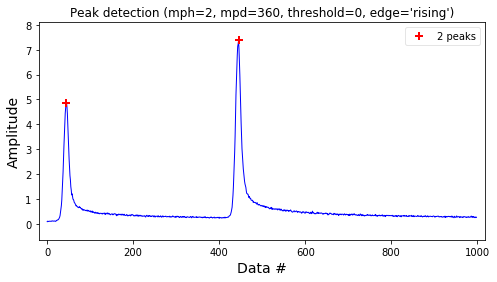

isi:  20 
vdcc:  60
Ca stats:
 [2.20000000e-03 4.87384800e+00 1.02471838e-02 2.22500000e-02
 7.36967100e+00 1.49610570e-02]
Ca stats:
 [2.20000000e-03 4.87384800e+00 1.02471838e-02 2.22500000e-02
 7.36967100e+00 1.49610570e-02 2.00000000e+01 6.00000000e+01]


[None, None, None]

In [314]:
%run analysis.ipynb
p=Pool(ncores)
#print(fnames)
p.starmap(all_analysis,product(fnames,sims[2:3]))
#all_analysis(fnames[-1])
#all_analysis("RSI20V90","R150ER2x")

In [313]:
def all_analysis(name,sim):
    print(sim,name)
    dataDirName = name.replace(".mdl","")
    dataType = "ppf/"+sim+"/"
    
    M=analysis(dataDirName,dataType)
    
    data_files=['ca.dat', 'ryr_mol.dat', 'serca_ca_flux.dat', 'vdcc_pq_ca_flux.dat', 'calbindin_mol.dat',\
            'serca_mol.dat', 'pmca&leak_ca_flux.dat', 'rrp.dat', 'ryr_ca_flux.dat']
    
    for data_file in data_files[0:1]:
        M.avg_dat(inFile="/dat/"+data_file, outFile="/"+data_file)
    M.conc_calc(inFile="/ca.dat", outFile="/CaConc")

    isi = int(M.dataDirName.split("I")[1].split("V")[0])
    vdcc = int(M.dataDirName.split("V")[1])
    print('isi: ', isi, '\nvdcc: ', vdcc)

    M.relppf(isi, vdcc, resample=1000)

    M.caStat(showFig=True)

In [335]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
result={}
for sim_type in sims[0:3]:
    result[sim_type]={}
    for name in fnames:
        loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'result'
        if os.path.isfile(loc+'.dat'):
            os.rename(loc+'.dat',loc)
        with open(loc,'r') as f:
            l=f.readlines()
            result[sim_type][name]=[float(a) for a in l[2].replace('\n','').split('\t')]
#/home/kabir/Project/tripartiteSynapse/results/ppf/R150ER2x/RSI20V120

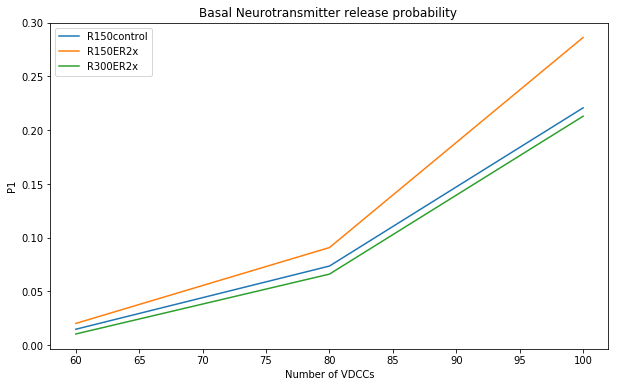

In [340]:
plt.figure(figsize=(10,6))
for sim_type in sims[0:3]:
    #print(result[sim_type])
    res=result[sim_type]
    xdata=[res[name][-1] for name in fnames]
    ydata=[res[name][0] for name in fnames]
    #print(ydata)
    plt.plot(xdata,ydata,label=sim_type)
plt.xlabel("Number of VDCCs")
plt.ylabel("P1")
plt.title("Basal Neurotransmitter release probability ")
plt.legend()
plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/P1VDCC.pdf")

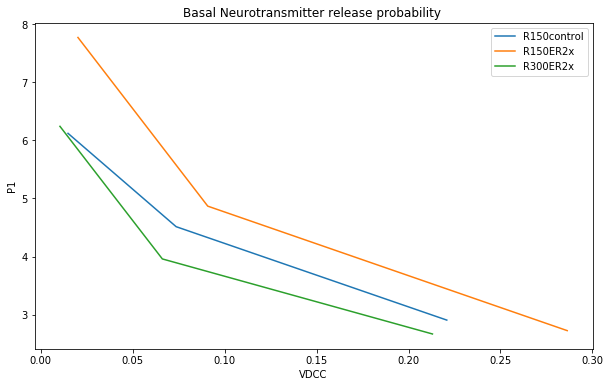

In [338]:
plt.figure(figsize=(10,6))
for sim_type in sims[0:3]:
    #print(result[sim_type])
    res=result[sim_type]
    xdata=[res[name][0] for name in fnames]
    ydata=[res[name][4] for name in fnames]
    #print(ydata)
    plt.plot(xdata,ydata,label=sim_type)
plt.xlabel("VDCC")
plt.ylabel("P1")
plt.title("Basal Neurotransmitter release probability ")
plt.legend()
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ppr.pdf")

In [356]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data={}
for sim_type in sims[0:3]:
    data[sim_type]={}
    name="RSI20V80"
    loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'CaConc'
    data[sim_type][name]=np.loadtxt(loc)
    

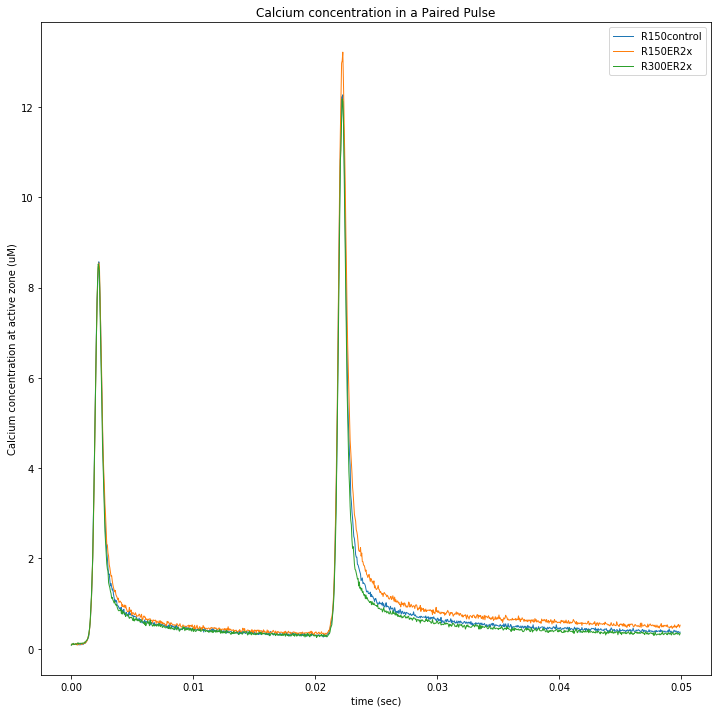

In [357]:
plt.figure(figsize=(12,12))
for sim_type in sims[0:3]:
    xdata=data[sim_type][name].T[0]
    ydata=data[sim_type][name].T[1]
    plt.plot(xdata,ydata,label=sim_type,lw="1")

plt.xlabel("time (sec)")
plt.ylabel("Calcium concentration at active zone (uM)")
plt.title("Calcium concentration in a Paired Pulse")
plt.legend()
plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/az.eps")

In [358]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data={}
for sim_type in sims[0:3]:
    data[sim_type]={}
    name="RSI20V80"
    loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'ryr_ca_flux.dat'
    data[sim_type][name]=np.loadtxt(loc)
    

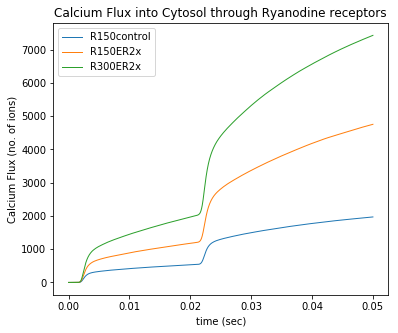

In [362]:
plt.figure(figsize=(6,5))
for sim_type in sims[0:3]:
    xdata=data[sim_type][name].T[0]
    ydata=data[sim_type][name].T[1]
    plt.plot(xdata,ydata,label=sim_type,lw="1")

plt.xlabel("time (sec)")
plt.ylabel("Calcium Flux (no. of ions)")
plt.title("Calcium Flux into Cytosol through Ryanodine receptors")
plt.legend()
plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ryr_flux.eps")

In [337]:
def faverage(data_file):
    dataDirName="RSI20V80"
    dataType="ppf/R300ER2x/"
    M=analysis(dataDirName,dataType)
    M.avg_dat(inFile="/dat/"+data_file, outFile="/"+data_file)
    
data_files=['az.dat', 'ryr_mol.dat', 'serca_ca_flux.dat', 'vdcc_pq_ca_flux.dat', 'calbindin_mol.dat',\
            'serca_mol.dat', 'pmca&leak_ca_flux.dat', 'rrp.dat', 'ryr_ca_flux.dat']

p=Pool(ncores-1)
p.starmap(faverage,product(data_files[-1:]))


Calculating Average of /dat/ryr_ca_flux.dat
RSI20V80
seeds:  3000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R300ER2x/RSI20V80/ryr_ca_flux.dat


[None]

In [255]:
name="RSI60V90"
outfolder="R150ER2x"
data_loc="/data/kabir/output/ppf/"+outfolder+'/'+name
seed_folders=os.listdir(data_loc)
for s in seed_folders:
    file=data_loc+'/'+s+'/'+'dat/ca.dat'
    print(s,file_len(file))
    

s_01547 9002
s_00027 9002
s_00119 9002
s_00499 9002
s_01843 9002
s_00387 9002
s_00089 9002
s_00342 9002
s_01922 9002
s_01393 9002
s_00784 9002
s_01093 9002
s_01405 9002
s_01973 9002
s_00830 9002
s_00056 9002
s_00606 9002
s_01255 9002
s_00066 9002
s_01114 9002
s_00340 9002
s_01363 9002
s_00270 9002
s_01443 9002
s_00087 9002
s_01070 9002
s_00508 9002
s_00095 9002
s_00249 9002
s_00217 9002
s_01373 9002
s_01277 9002
s_01178 9002
s_00012 9002
s_00695 9002
s_01647 9002
s_00223 9002
s_00931 9002
s_01012 9002
s_00793 9002
s_00505 9002
s_00669 9002
s_00461 9002
s_01418 9002
s_00116 9002
s_01251 9002
s_00068 9002
s_00584 9002
s_00051 9002
s_00082 9002
s_00380 9002
s_00825 9002
s_01716 9002
s_01407 9002
s_00305 9002
s_00715 9002
s_01154 9002
s_00679 9002
s_00837 9002
s_00246 9002
s_00859 9002
s_00378 9002
s_01458 9002
s_00968 9002
s_00419 9002
s_00561 9002
s_01553 9002
s_01250 9002
s_00997 9002
s_00638 9002
s_01768 9002
s_01753 9002
s_00757 9002
s_01958 9002
s_01482 9002
s_00120 9002
s_00438 9002

Process ForkPoolWorker-267:
Process ForkPoolWorker-269:
Process ForkPoolWorker-271:
Process ForkPoolWorker-273:
Process ForkPoolWorker-264:
Process ForkPoolWorker-268:
Process ForkPoolWorker-272:
Process ForkPoolWorker-270:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Fo

s_01651 9002
s_00189 9002
s_00832 9002
s_00058 9002
s_00779 9002
s_01386 9002
s_01124 9002
s_00398 9002
s_01077 9002
s_01604 9002
s_01536 9002
s_01613 9002


  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()


KeyboardInterrupt: 

  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


In [237]:
def file_len(fname):
    i=-1
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [246]:
"hi.bye".split('.')[0]

'hi'

In [281]:
#combine glutamate release data for each seed
data_loc="/data/kabir/output/ppf/"+outfolder+'/'
#get seed folders
seed_folders=os.listdir(data_loc)

count=0
if "Average" in seed_folders:
    seed_folders.remove("Average")
for s in seed_folders:
    s=data_loc+s+"/dat/"
    file_names=os.listdir(s)
    output=[]
    for f_name in file_names:
        if 'vdcc.' in f_name:
            with open(s+f_name,'r') as f:
                output=output+f.readlines()
    with open(s+'rel.dat','w') as f:
        f.writelines(output)
    count+=len(output)

count/500

0.67

In [4]:
%run testLocal.py norm/RSI20V90
norm_ppf=ppf(resample=10)
%run testLocal.py AD/RSI20V90
AD_ppf=ppf(resample=10)
print("normal PPR = ",norm_ppf[4])
print("AD PPR     = ",AD_ppf[4])

dataPath :  /data/kabir/output/ppf/norm/RSI20V90
resultPath :  /home/kabir/Project/tripartiteSynapse/results/ppf/norm/RSI20V90
isi:  20 vdcc:  90
seeds:  500
[0.0382, 0.008072174428244226, 0.34719999999999995, 0.02584879107424562, 9.611293613731359, 2.5516180832777358, 20.0, 90.0]
dataPath :  /data/kabir/output/ppf/AD/RSI20V90
resultPath :  /home/kabir/Project/tripartiteSynapse/results/ppf/AD/RSI20V90
isi:  20 vdcc:  90
seeds:  500
[0.09159999999999999, 0.016044936896105262, 0.49840000000000007, 0.020293841430345325, 5.623162580693527, 1.070975085559397, 20.0, 90.0]
normal PPR =  9.611293613731359
AD PPR     =  5.623162580693527


In [9]:
%run testLocal.py AD/RSI40V90

dataPath :  /data/kabir/output/ppf/AD/RSI40V90
resultPath :  /home/kabir/Project/tripartiteSynapse/results/ppf/AD/RSI40V90


In [10]:
AD_ppf=ppf(resample=10)

isi:  40 vdcc:  90
seeds:  500
[0.0922, 0.014462364951832738, 0.403, 0.01782694589659148, 4.509857438817555, 0.8958789564708997, 40.0, 90.0]


In [261]:
%run averaging1.ipynb

averager("/data/kabir/output/ppf/norm/RSI40V90","ca.dat",[2,3])

In [208]:
outfolder='norm/RSI20V40'
data_file="/data/kabir/output/ppf/norm/RSI20V40/Average/ca.dat"
data1=np.loadtxt(data_file)

outfolder='AD/RSI40V90/'
data_file="/data/kabir/output/ppf/AD/RSI40V90/Average/ca.dat"
data2=np.loadtxt(data_file)

In [3]:
#plt.plot(data1.T[0,:],data1.T[1,:],label='normal')#*1e15/N_avo/vol_er*1e6)
plt.plot(data2.T[0,:],data2.T[1,:],label='AD')#*1e15/N_avo/vol_er*1e6)
plt.legend()

NameError: name 'plt' is not defined

In [11]:
data1.T[:,0]

array([   0.,    0.,   57., 5872.])